In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, memory_summarizer_node, graph_and_exploitation_inference_node, exposure_manager_node, event_summarizer_node, firewall_node, save_iteration_node
from configuration.state import HoneypotStateReact
from configuration import memory
nest_asyncio.apply()
import benchmark.benchmark as b


def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-5",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


In [3]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "persistence_node"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "persistence_node"

In [4]:
def build_react_graph():
    graph = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    #graph.add_node("memory_summarizer", memory_summarizer_node.memory_summarizer)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    graph.add_node("graph_and_exploitation_inference", graph_and_exploitation_inference_node.graph_and_exploitation_inference)
    graph.add_node("exposure_manager", exposure_manager_node.exposure_manager)
    graph.add_node("firewall_manager", firewall_node.firewall_executor)
    graph.add_node("persistence_node", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge("network_gathering", "event_summarizer")
    graph.add_edge("event_summarizer", "graph_and_exploitation_inference")
    graph.add_edge("graph_and_exploitation_inference", "exposure_manager")
    graph.add_edge("exposure_manager", "firewall_manager")
    graph.add_conditional_edges("firewall_manager", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "persistence_node")
    graph.add_edge("persistence_node", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:36171/devtools/browser/971d7a2d-a815-49b5-98d0-89f6326288ea
INFO:pyppeteer.launcher:terminate chrome process...


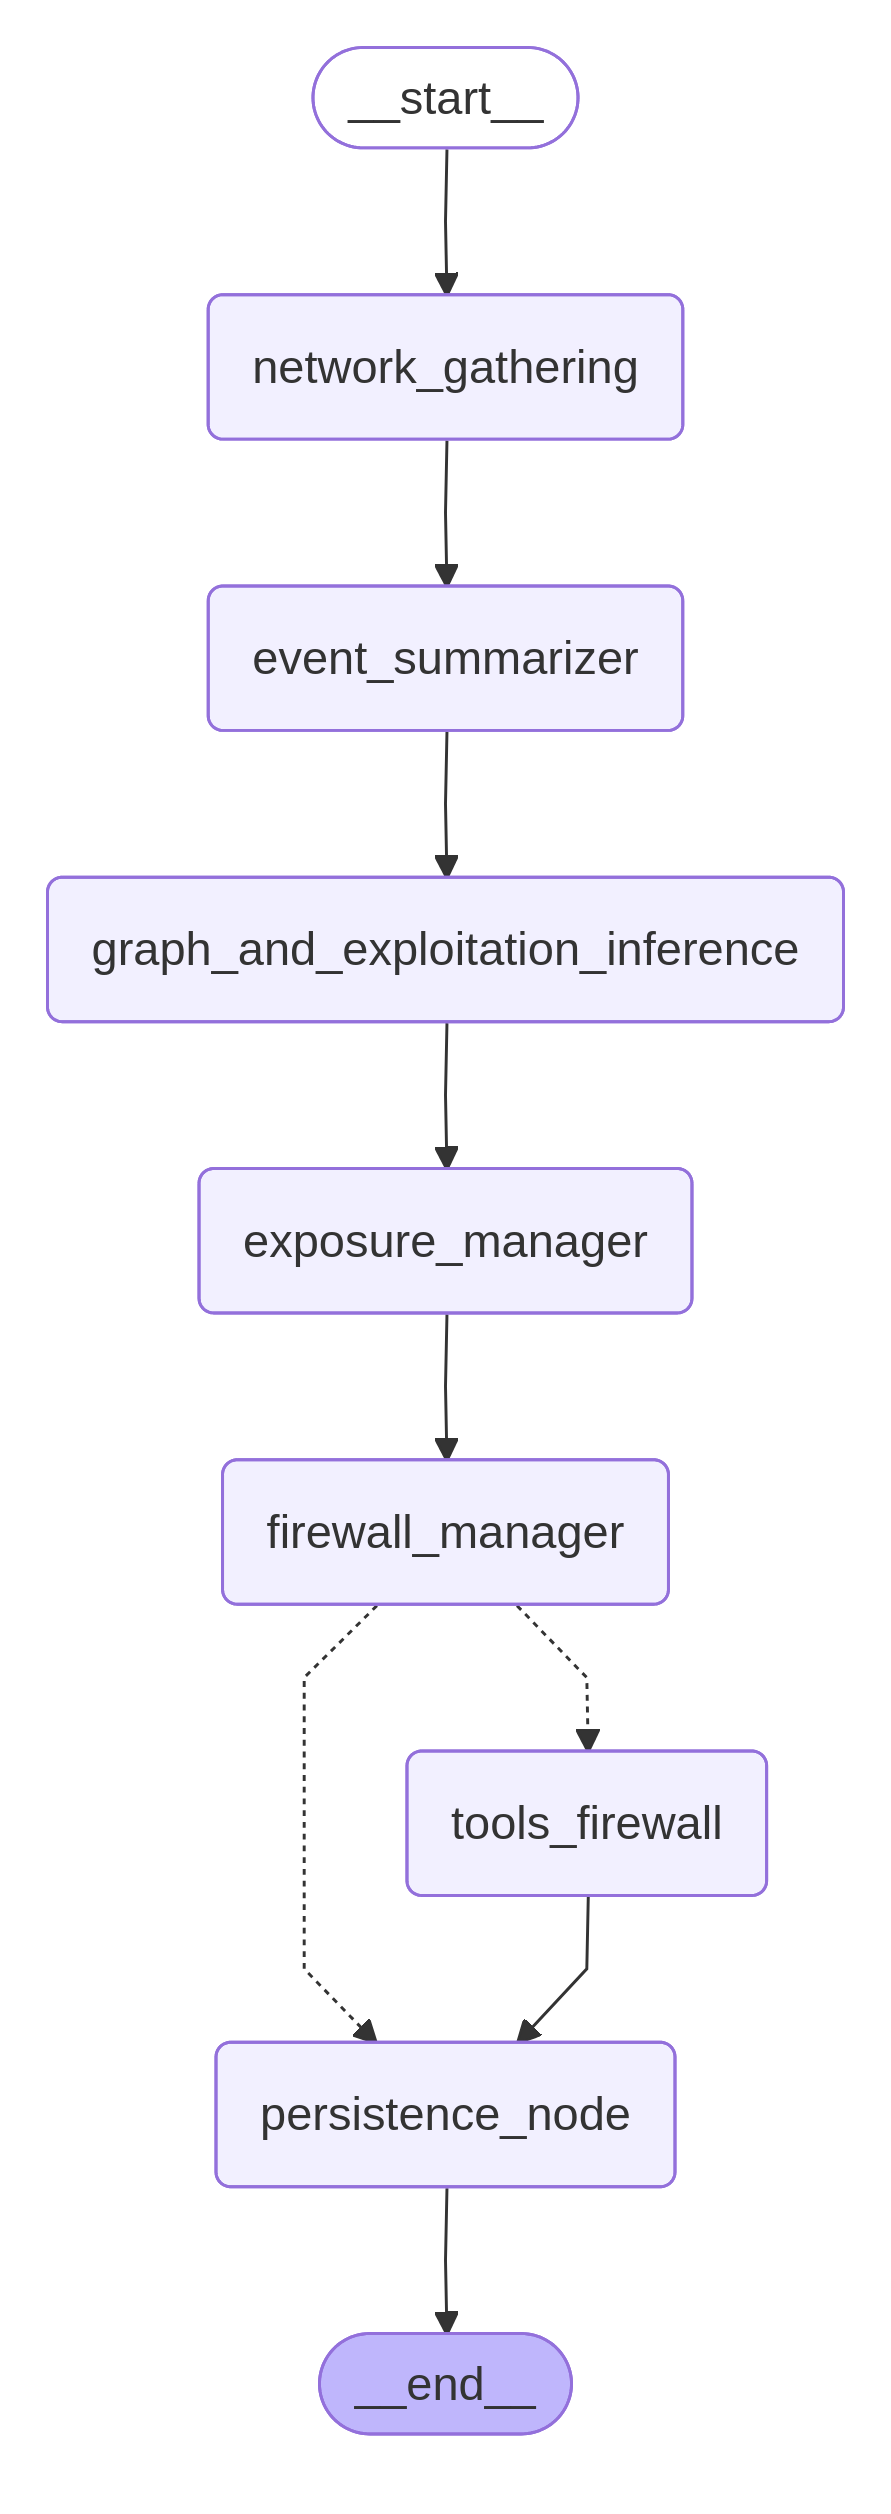

In [5]:
graph = build_react_graph()
display_graph(graph)

## Single Iteration

In [6]:
episodic_memory = memory.EpisodicMemory()

In [9]:
responses = []
for i in range(1):
    initial_state = HoneypotStateReact(
        messages=[]
    )
    response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"fast", "time_window":2, "epoch_num":i+1, "model_config":"large:4.1"}})
    responses.append(response)

INFO:nodes.network_gathering_node:Network gathering Node
INFO:nodes.event_summarizer_node:Summarizer Agent
INFO:nodes.graph_and_exploitation_inference_node:Inference Agent
INFO:nodes.graph_and_exploitation_inference_node:Using: gpt-4.1
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.exposure_manager_node:Exploitation Agent
INFO:nodes.exposure_manager_node:Exposure registry: {'172.20.0.5': {'service': 'cve-2014-6271-web-1', 'first_epoch': 1, 'last_epoch': 1, 'epochs_exposed': 0, 'last_level': 0, 'prev_level': 0}}
INFO:nodes.exposure_manager_node:Using: gpt-4.1
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.firewall_node:Firewall Agent
INFO:nodes.firewall_node:Using: gpt-4.1
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.save_iteration_n

In [14]:
for response in responses:
    for m in response['messages']:
        m.pretty_print()

================================ Human Message =================================

Threat Overview:

{
  "time_range": { "first_seen": "2025-09-12T13:30:30.728930+02:00", "last_seen": "2025-09-12T13:30:55.540974+02:00" },
  "total_alerts": 68,
  "high_severity": { "count": 0, "examples": [] },
  "top_categories": [
    {"name": "Attempted Information Leak", "count": 52},
    {"name": "Potentially Bad Traffic", "count": 12},
    {"name": "Misc activity", "count": 3}
  ],
  "primary_attack_types": [
    {"signature": "POSSBL PORT SCAN (NMAP -sS)", "count": 52},
    {"signature": "ET SCAN Suspicious inbound to mySQL port 3306", "count": 6},
    {"signature": "ET SCAN Suspicious inbound to MSSQL port 1433", "count": 4},
    {"signature": "ET SCAN Potential SSH Scan", "count": 1},
    {"signature": "GPL ICMP PING *NIX", "count": 3}
  ],
  "threat_level": "Medium",
  "new_since_last_summary": 68
}

Source Analysis:

{
  "top_attackers": [ {"ip": "192.168.100.2", "count": 68} ],
  "new_attacke

In [9]:
for i in episodic_memory.get_recent_iterations():
    for k,v in i.value.items():

        print(f"Key: {k}\nValue: {v}")

Key: id
Value: iteration_1
Key: iteration_number
Value: 1
Key: timestamp
Value: 1756835043
Key: datetime
Value: 2025-09-02T19:44:03.596018
Key: currently_exposed
Value: {'ip': '172.20.0.5', 'service': 'http (80/tcp)', 'current_level': 0, 'epoch': 1}
Key: exposure_registry
Value: {'172.20.0.5': {'service': 'http (80/tcp)', 'first_epoch': 1, 'last_epoch': 1, 'epochs_exposed': 0, 'last_level': None, 'prev_level': None}}
Key: rules_added
Value: [{'rules_added_current_epoch': 'ALLOW 192.168.100.0/24 -> 172.20.0.5:80 (tcp)'}, {'rules_added_current_epoch': 'ALLOW 172.20.0.5 -> 192.168.100.0/24 (tcp)'}]
Key: honeypots_exploitation
Value: []
Key: lockdown_status
Value: False
Key: rules_removed
Value: []
Key: firewall_reasoning
Value: 
Key: inferred_attack_graph
Value: {'interesting': [], 'edges': [], 'edge_updates': []}
Key: reasoning_inference
Value: No alerts or evidence were retrieved in this epoch: no scan, exploitation, or other phase detected. Therefore, the attack graph, exploitation lev

## Benchmark

In [7]:
episodic_memory = memory.EpisodicMemory()
dir_name = "all_exploitable_small"

config_dict = {
            "max_epochs": 15,
            "attack_duration": 240,
            "monitor_accumulation_wait": 5,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": dir_name
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":3, 
            "prompt":"eve",
            "epoch_num": epoch_num,
            "model_config": "small:4.1"
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)

INFO:benchmark.benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.benchmark.Orchestrator:
INFO:benchmark.benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.benchmark.Orchestrator:============================================================

INFO:benchmark.benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.benchmark.Orchestrator:Starting attacker script with a fallback timeout of 240s...
INFO:benchmark.benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.benchmark.Atta

In [ ]:
import pickle 
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "wb") as f:
    pickle.dump(responses, f)

In [12]:
with open(f"./benchmark/benchmark_results/{dir_name}/responses.pkl", "rb") as f:
    saved_responses = pickle.load(f)

for res in saved_responses:
    for m in res["messages"]:
        m.pretty_print()

================================ Human Message =================================

Target Analysis:

{"honeypots":[{"ip":"172.20.0.2","service_name":"unauthorized-rce-docker-1","services_under_attack":["tcp/2375","tcp/636","tcp/137","tcp/443","tcp/80","tcp/2376"],"compromise_indicators":[{"signature":"POSSBL PORT SCAN (NMAP -sS)","count":13,"severity":2,"new":true,"evidence_quotes":[],"payload":""},{"signature":"ET SCAN Suspicious inbound to mySQL port 3306","count":4,"severity":2,"new":true,"evidence_quotes":[],"payload":""}]},{"ip":"172.20.0.3","service_name":"s2-057-struts2-1","services_under_attack":["tcp/8080","tcp/3306","ssh@tcp/22","tcp/514","tcp/110","tcp/1433","tcp/161","tcp/389","tcp/465","tcp/3306"],"compromise_indicators":[{"signature":"POSSBL PORT SCAN (NMAP -sS)","count":11,"severity":2,"new":true,"evidence_quotes":["ET SCAN Potential SSH Scan"],"payload":""},{"signature":"ET SCAN Suspicious inbound to mySQL port 3306","count":2,"severity":2,"new":true,"evidence_quotes":[]

In [10]:
for n,i in enumerate(episodic_memory.get_recent_iterations(limit=20)):
    print(f"Epoch: {n+1}")
    for k,v in i.value.items():

        print(f"Key: {k}\n")
        print(v)
    print("=" * 130)
